# Assignment 6: Linear regression
<B>Objective:</B> To gets hands on experience on multiple linear regression. 
* Cost Function for regression
* Gradient Descent, Learning rates
* Feature Normalization
* Iterative method vs direct method for regression
* Using the statsmodels library for regression
* How to work with categorical variables / one hot encoding

<B>Problem:</B> We will solve two set of problems 
1. Predicting house price
2. Predicting weather station maintenence request counts

## Introduction
Linear Regression is a supervised machine learning algorithm where the predicted output is continuous and has a constant slope. Is used to predict values within a continuous range (e.g. sales, price). 
Linear regression is computationally efficient, simple and easy to interpret. However, the algorithm fails to capture non-linear behavior.   

<b>Ordinary Least Squares (OLS) / Simple linear regression:</b> Simple linear regression uses traditional slope-intercept form, where $\theta_0$ and $\theta_1$ are the variables our algorithm will try to “learn” to produce the most accurate predictions. $x$ represents our input data and $\hat{y}$ represents our prediction.

$$\hat {y} = \mathbf{X}\boldsymbol\theta + \varepsilon= \theta_{1}x+\theta_{0} + \varepsilon$$

The prediction is associated with a prediction error $\varepsilon$. Also note that we include an intercept term $\theta_0$ so that our model is not forced to $\hat{y}(0) = 0$.
In order to estimate the values of $\boldsymbol\theta$ we need to minimize a cost function. In the case of linear regression it is given by

$$J(\theta) = \frac{1}{2m}\sum_{i=1}^{m}(\hat {y}_{i}-y_{i})^{2}$$

which in intuitively seeks to minimize the squared distances between our model's prediction and the true value, resulting in the best fit. In this case, $m$ is the amount of training samples. 

<p align="center">
  <img width="49%" src="https://aegis4048.github.io/jupyter_images/multiple_linear_regression_por_vr.gif" />
      <img width="49%" src="https://aegis4048.github.io/jupyter_images/multiple_linear_regression_por_brittle.gif" />
</p>

The least squares problem we describe above can be extended to multivariate data sets. In multivariate regression we seek a set of parameters $\textbf{$\Theta$} = [\theta_{0} \quad \theta_{1} \quad \cdots \quad \theta_{n}]^{T}$ which minimizes the the cost function  
$$\textbf{J($\Theta$)}=\frac{1}{2m}(\textbf{X$\Theta$} -\hat{\textbf{Y}})^{T}(\textbf{X$\Theta$} -\hat{\textbf{Y}}),$$
such that we model the multivariate data on the form $\hat{\textbf{Y}} = \textbf{X$\Theta$}$. Graphically, as we see in the figure above, this results in fitting a plane with $n$ dimensions to the data set. In their case they use `Porosity`, `VR` and `Brittleness` ($n=3$) to predict `Gas Prod.` (pairwise, though, so ignore the $R^2$-values. When plotting all features we get a 4D figure that is not very human viewable.). 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings


warnings.filterwarnings('ignore')
plt.style.use("ggplot")
np.random.seed(1)

## Predicting house prices  

### Loading the data from a csv file
The columns represent the surface area, number of rooms and the price of the apartment. 

In [2]:
housing_data = pd.read_csv('housing_data.csv', names=["surface_area", "n_rooms", "price"])

# all cols except for price
X = housing_data.loc[:, housing_data.columns != "price"]
# just the price col
y = housing_data.loc[:, "price"]

housing_data.head()

,surface_area,n_rooms,price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


### Data Exploration
Plot the data and have a look.  
Note the large difference in the scale of "number of room variables" and "surface area". 
* "Number of room" has a range [1.0,5.0]
* "Surface area" has a range [500,4500]

This can cause problems during the cost minimization step when using gradient descent.

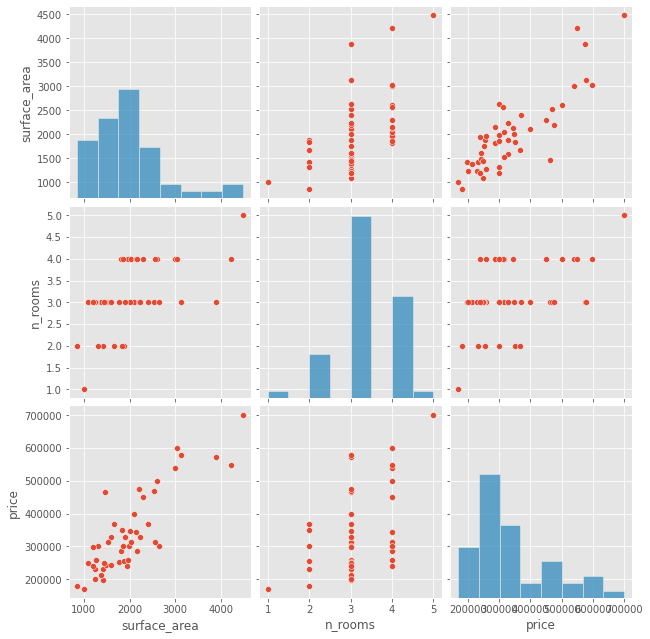

In [3]:
sns.pairplot(housing_data, height=3)

From the scatterplots we can see that there is a clear relationship between `surface_area`-`price` and `n_rooms`-`price`, and we observe from the distribution plots that most houses have areas less than ~2500 sq.ft., have 3-4 rooms and cost less than 400 kUSD.

### Feature normalization  
The input feature vectors are normalized so that they have comparable scales. Here we standardize by subtracting the mean and dividing by the standard deviation. The normalization step might not help in the calculation of the least squares solution, but might aid in data visualization when looking at multivariate relationships between the data features, and also gives us more interpretable regression weights for evaluating the ANOVA. *Note: The choice of normalization will change the optimal learning rate.*

#### When to normalize data in regression  

**Question**:   
"*Under what circumstances should the data be normalized/standardized when building a regression model? When i asked this question to a stats major, he gave me an ambiguous answer "depends on the data". But what does that really mean? It should either be an universal rule or a check list of sorts where if certain conditions are met then the data either should/ shouldn't be normalized.*"  

**Answer**:  
"*Sometimes standardization helps for numerical issues (not so much these days with modern numerical linear algebra routines) or for interpretation, as mentioned in the other answer. Here is one "rule" that I will use for answering the answer myself: Is the regression method you are using invariant, in that the substantive answer does not change with standardization? Ordinary least squares is invariant, while methods such as lasso or ridge regression are not. So, for invariant methods there is no real need for standardization, while for non-invariant methods you should probably standardize. (Or at least think it through).*"  
(https://stats.stackexchange.com/a/202002)

In [4]:
# Standardizing the data
X_mean = X.mean()
X_std = X.std()
X_norm = (X - X_mean) / X_std

### The bias term
We simply add a column vector of 1 to add the bias term, $\theta_0$, such that a single prediction from the linear model we are about to fit is on the form $\hat{y} = 1 \cdot \theta_0 + \text{a linear combination of our input data}$  
To illustrate the importance of the bias term, consider this plot of two fitted regression lines:
![](http://4.bp.blogspot.com/-iuCGuquEab0/UO1CYEsmGKI/AAAAAAAAAJo/v3XbylKs4_g/s1600/Origin.png)  
Without the intercept/bias-term we force the regression line to find the least squares solution that goes through origo, when we can easily see that the leftmost values in our dataset (the scatter points) are positive on the y-axis. This principle also holds for multivariate regression, although harder to visualize.

In [5]:
import statsmodels.api as sm


X_padded = sm.add_constant(X_norm)

# This can also be accomplished with numpy like so:
# X_padded = np.column_stack((np.ones((m, 1)), X_norm))

### Implementing gradient descent of the cost function
$$\textbf{J($\Theta$)}=\frac{1}{2m}(\textbf{X$\Theta$} -\hat{\textbf{Y}})^{T}(\textbf{X$\Theta$} -\hat{\textbf{Y}})$$  
The gradient descent method starts with a set of initial parameter values of $\mathbf{\Theta_0 = 0}$, and then follows an iterative procedure, changing the values of $\boldsymbol\Theta$ so that $\textbf{J($\Theta$)}$ is minimized. Recall that $\textbf{$\Theta$} = [\theta_{0} \quad \theta_{1} \quad \cdots \quad \theta_{n}]^{T}$. Then each parameter is updated by
$$\theta_j \rightarrow \theta_j - \alpha \frac{\partial}{\partial \theta_j}\textbf{J($\Theta$)}$$

In [6]:
def compute_cost(X, y, theta):
    """The cost function, J(theta), describing the goodness of fit."""
    y_hat = X @ theta
    return np.mean((y - y_hat) ** 2) / (2 * len(y))


def compute_gradient(X, y, theta):
    """The gradient of the cost function."""
    return X.T @ (X @ theta - y) / (2 * len(y))


def gradient_descent(X, y, alpha, n_iters=1000):
    """Perform gradient descent of the regression cost function."""
    # Add extra dim on 1D y
    y = y.reshape(-1, 1)
    
    # Initialize solution and history arrs
    m, n = X.shape
    theta = np.zeros((n, 1))
    cost_history = np.zeros((n_iters, 1))
    theta_history = np.zeros((n_iters, n))
    
    # Solve iteratively for theta
    for i in range(n_iters):
        theta -= alpha * compute_gradient(X, y, theta)
        theta_history[i] = theta.flatten()
        cost_history[i] = compute_cost(X, y, theta)
    return theta.flatten(), cost_history, theta_history

We set a fairly large value for our step size $\alpha$ (the bigger it is the faster our algorithm converges, but if it is too big our algorithm may diverge, so be careful and test several values for the step). Let's do gradient descent and visualize our results.

theta = [340412.65957436 110630.38827246  -6648.81226444]


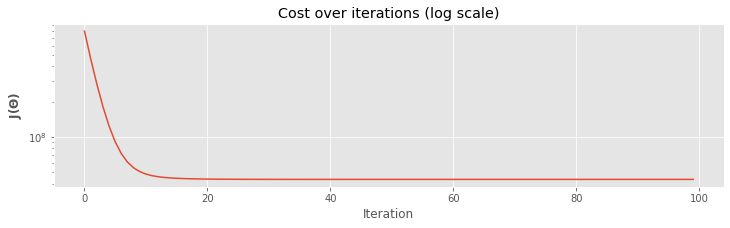

In [7]:
theta, cost_history, theta_history = gradient_descent(X_padded.values, y.values, 0.5, 100)
print("theta =", theta) # cost, surface_area, n_rooms

plt.figure(figsize=(12, 3))
plt.plot(cost_history)
plt.yscale("log")
plt.title("Cost over iterations (log scale)")
plt.xlabel("Iteration")
plt.ylabel(r"$\mathbf{J(\Theta)}$");

As we can see, we managed to pick a learning rate that resulted in fast loss convergence of the gradient descent.  

### Plotting the contours of the cost function  
Now that we collected data for all parameter combinations we tried in the GD, we can plot the contour of the cost surface for $\mathbf{J(\Theta)}$. This way we can see for our own eyes how gradient descent traverses through space.

In [8]:
N = 500

# Generate N hypothetical theta_j values
x1 = np.linspace(100000, 400000, N)
x2 = np.linspace(20000, 140000, N)
x3 = np.linspace(-30000, 30000, N)

# Initialize cost matrices
Z_12 = np.zeros(shape=(N, N))
Z_13 = np.zeros(shape=(N, N))
Z_23 = np.zeros(shape=(N, N))

# Compute hypothetical costs over a grid of every permutation of parameter space
for i, x1_i in enumerate(x1):
    for j, x2_j in enumerate(x2):
        theta_ij = np.array([x1_i, x2_j, theta[2]])
        Z_12[j, i] = compute_cost(X_padded.values, y.values, theta_ij)
for i, x1_i in enumerate(x1):
    for k, x3_k in enumerate(x3):
        theta_ik = np.array([x1_i, theta[1], x3_k])
        Z_13[k, i] = compute_cost(X_padded.values, y.values, theta_ik)
for i, x2_i in enumerate(x2):
    for j, x3_j in enumerate(x3):
        theta_ij = np.array([theta[0], x2_i, x3_j])
        Z_23[j, i] = compute_cost(X_padded.values, y.values, theta_ij)

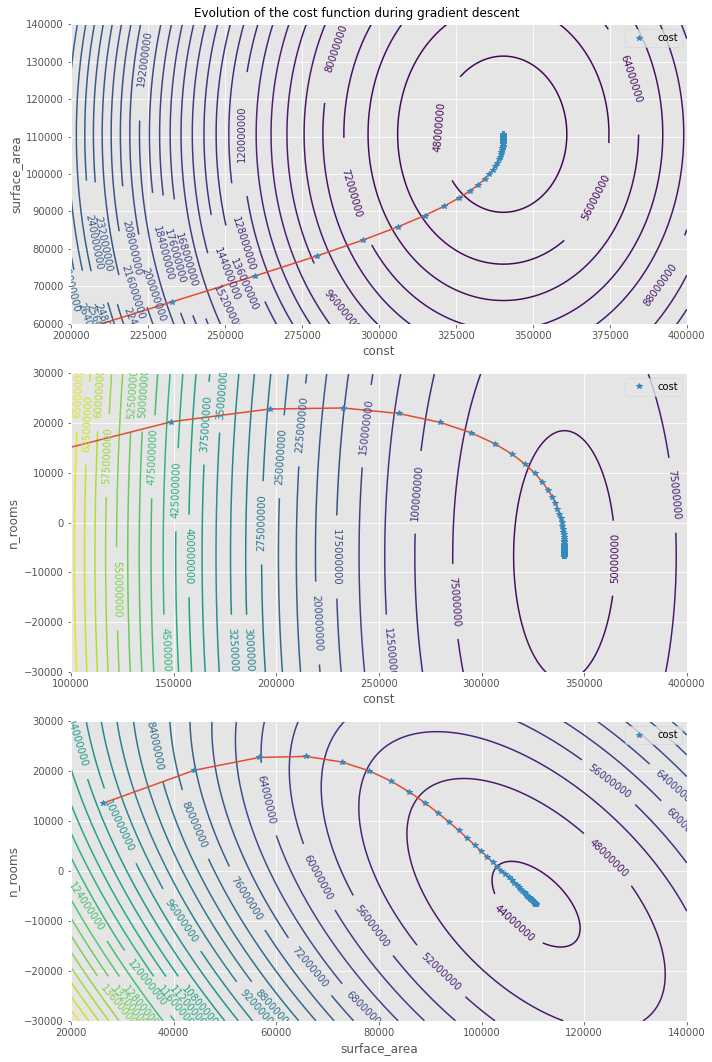

In [9]:
fig, ax = plt.subplots(figsize=(10, 15), nrows=3, ncols=1)
plt.suptitle("Evolution of the cost function during gradient descent")

contours = ax[0].contour(x1, x2, Z_12, 100)
ax[0].clabel(contours, inline=True)
ax[0].plot(theta_history[:, 0], theta_history[:, 1])
ax[0].plot(theta_history[:, 0], theta_history[:, 1], "*", label="cost")

ax[0].set_xlim(200000, 400000)
ax[0].set_ylim(60000, 140000)
ax[0].set_xlabel('const')
ax[0].set_ylabel('surface_area')
ax[0].legend(loc="upper right")

contours = ax[1].contour(x1, x3, Z_13, 30)
ax[1].clabel(contours, inline=True)
ax[1].plot(theta_history[:, 0], theta_history[:, 2])
ax[1].plot(theta_history[:, 0], theta_history[:, 2], "*", label="cost")

ax[1].set_xlim(100000, 400000)
ax[1].set_ylim(-30000, 30000)
ax[1].set_xlabel('const')
ax[1].set_ylabel('n_rooms')
ax[1].legend(loc="upper right")

contours = ax[2].contour(x2, x3, Z_23, 30)
ax[2].clabel(contours, inline=True)
ax[2].plot(theta_history[:, 1], theta_history[:, 2])
ax[2].plot(theta_history[:, 1], theta_history[:, 2], "*", label="cost")

ax[2].set_xlim(20000, 140000)
ax[2].set_ylim(-30000, 30000)
ax[2].set_xlabel('surface_area')
ax[2].set_ylabel('n_rooms')
ax[2].legend(loc="upper right")

plt.tight_layout()
plt.show()

Note that the values of the contour ellipses correspond to cost function values for the parameters that intersect with the ellipse. We start out at very high cost values, but settle in what we estimate to be the global minimum. Even though we only visualize two parameters at a time, know that the different plots "happen" at the same time, since we update all parameters simultaneously in a vector.

### Make predictions using the trained model
Remember that the input features were normalized so we need to do the same with the new input features on which we want to make make predictions.

In [10]:
def standardize(val, mean, std):
    return (val - mean) / std


house_norm_padded = np.array([
    1, # for bias term
    standardize(1650, X_mean["surface_area"], X_std["surface_area"]), 
    standardize(3, X_mean["n_rooms"], X_std["n_rooms"])
])
predicted_price = house_norm_padded @ theta
print("Predicted price of a 1650 sq-ft, 3 br house (using gradient descent):", predicted_price, "USD")

Predicted price of a 1650 sq-ft, 3 br house (using gradient descent): 293081.608386061 USD


### Solution using the normal equation
Generally for very large problems due to memory requirements gradient descent algorithm is used for minimization but since here we are working with a small dataset with a small number of feature vectors $X$, we can use the direct method for finding the minima. This involves invoking the closed-form solution to linear regression, which follows from  

$$
\mathbf{Y = X \Theta + \varepsilon}, \quad \varepsilon \sim \mathcal{N}(\mathbf{0}, \boldsymbol\Sigma)\\
\mathbf{X^\top Y = X^\top X \Theta} \\
\mathbf{(X^\top X)^{-1}X^\top Y = (X^\top X)^{-1}X^\top X \Theta} \\
\mathbf{\Theta=(X^\top X)^{-1}X^\top Y}
$$

In [11]:
def solve_normal_equation(X, y):
    theta = np.linalg.pinv(X.T @ X) @ X.T @ y
    return pd.Series(theta.values, index=X.columns)

theta_normal = solve_normal_equation(X_padded, y)
print("Theta calculated by Normal Equation\n", theta_normal)
price_normal = house_norm_padded @ theta_normal
print("\nPredicted price of a 1650 sq-ft, 3 br house (using normal equation):", price_normal, "USD")

Theta calculated by Normal Equation
 const           340412.659574
surface_area    110631.050279
n_rooms          -6649.474271
dtype: float64

Predicted price of a 1650 sq-ft, 3 br house (using normal equation): 293081.4643348962 USD


### Regression using `statsmodels`  
Implementing the regression methods ourselves gives us some understanding of how they work, but well known statistics packages such as `statsmodels` includes many helpful features that aren't as easily implemented, such as ANOVA.

In [12]:
model = sm.OLS(y, X_padded).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Ordinary least squares
==========================================================================
Model:                 OLS                Adj. R-squared:       0.721     
Dependent Variable:    price              AIC:                  1179.5358 
Date:                  2022-03-21 09:54   BIC:                  1185.0862 
No. Observations:      47                 Log-Likelihood:       -586.77   
Df Model:              2                  F-statistic:          60.38     
Df Residuals:          44                 Prob (F-statistic):   2.43e-13  
R-squared:             0.733              Scale:                4.3652e+09
--------------------------------------------------------------------------
                Coef.     Std.Err.     t    P>|t|     [0.025      0.975]  
--------------------------------------------------------------------------
const        340412.6596  9637.2385 35.3226 0.0000 320990.0816 359835.2375
surface_area 110631.0503 11757.6997  9.4092 0.0000  86934.9636 134327.1369
n_rooms       -6649.4743 11757.6997 -0.5655 0.5746 -30345.5609  17046.6124
--------------------------------------------------------------------------
Omnibus:                 4.083           Durbin-Watson:              1.826
Prob(Omnibus):           0.130           Jarque-Bera (JB):           2.977
Skew:                    0.567           Prob(JB):                   0.226
Kurtosis:                3.484           Condition No.:              2    
==========================================================================

"""

### We can also fit regularized regression in `statsmodels`  
In regularized regression we modify the cost function to include a penalty on parameter scales, such that it looks like  
$$\textbf{J($\Theta$)}_R =\frac{1}{2m}(\textbf{X$\Theta$} -\hat{\textbf{Y}})^{T}(\textbf{X$\Theta$} -\hat{\textbf{Y}}) + \alpha \mathbf{R}(\Theta),$$
where $\mathbf{R}(\Theta)$ can be either $\mathbf{R}(\Theta) = ||\Theta||^2_2 = \Theta^\top \Theta$ in the case of ridge regression, or $\mathbf{R}(\Theta) = ||\Theta||_1 = \sum_{i=0}^n |\theta_i|$ for LASSO.
Statsmodels supports ridge-, LASSO- and elastic-net-regularization (a linear combination of ridge and LASSO, governed by `L1_wt`).  

**A part of the docstring of `sm.OLS.fit_regularized`**:  
Return a regularized fit to a linear regression model.

Parameters
- method: str  
    Either ‘elastic_net’ or ‘sqrt_lasso’.

- alpha: scalar or array_like  
    The penalty weight. If a scalar, the same penalty weight applies to all variables in the model. If a vector, it must have the same length as params, and contains a penalty weight for each coefficient.

- L1_wt: scalar  
    The fraction of the penalty given to the L1 penalty term. Must be between 0 and 1 (inclusive). If 0, the fit is a ridge fit, if 1 it is a lasso fit.


(https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit_regularized.html)

In [13]:
# The regularization param is a design choice
reg_alpha = 4.20 # Also known as lambda in the literature

lm = sm.OLS(y, X_padded)
lasso_model = lm.fit_regularized(method="sqrt_lasso", alpha=reg_alpha)
ridge_model = lm.fit_regularized(method="elastic_net", alpha=reg_alpha, L1_wt=0)

print("LASSO Theta:", lasso_model.params, end="\n\n", sep="\n")
print("Ridge Theta:", pd.Series(ridge_model.params, index=X_padded.columns), sep="\n")

LASSO Theta:
const           334634.336608
surface_area    101007.086849
n_rooms             -0.007380
dtype: float64

Ridge Theta:
const           65463.972995
surface_area    19314.678825
n_rooms          8407.132918
dtype: float64


## Example 2: Predicting request count  
#### Data Description
* date : yyyy-mm-dd format
* calendar_code : 0 or 1 (a code describing certain calendar events)
* request_count : an integer (the number of support requests received on that date)
* site_count : an integer (the number of sites operating on that date)
* max_temp : a float (max temperature for that day in degrees Celsius)
* min_temp : a float (min temperature for that day in degrees Celsius)
* precipitation : a float (millimeters of precipitation on that date)
* events : a string (description of weather events on that date)

Our aim is to predict the request_count when the other parameters are given.

In [14]:
met = pd.read_csv("met.csv", index_col=0)
met = met.dropna()
met.date = pd.to_datetime(met.date, format="%Y-%m-%d")
met.head()

,date,calendar_code,request_count,site_count,max_temp,min_temp,precipitation,events
0,2014-09-01,0.0,165.0,6,30.6,22.8,0.0,Rain
1,2014-09-02,1.0,138.0,7,32.8,22.8,15.5,Rain-Thunderstorm
2,2014-09-03,1.0,127.0,7,29.4,18.3,0.0,None
3,2014-09-04,1.0,174.0,7,29.4,17.2,0.0,None
4,2014-09-05,1.0,196.0,7,30.6,21.7,0.0,Fog


In [15]:
# Helpful summary method
met.describe()

,calendar_code,request_count,site_count,max_temp,min_temp,precipitation
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000
mean,0.585526,263.072368,11.282895,9.831579,0.638158,2.875658
std,0.494259,111.248073,3.476349,9.837780,9.221110,6.893533
min,0.000000,0.000000,0.000000,-8.900000,-16.700000,0.000000
25%,0.000000,183.750000,9.000000,3.300000,-5.150000,0.000000
50%,1.000000,249.500000,11.000000,6.950000,-0.850000,0.000000
75%,1.000000,324.750000,15.000000,17.925000,5.725000,1.300000
max,1.000000,615.000000,17.000000,32.800000,22.800000,42.400000


In [25]:
X = met.loc[:, met.columns != "request_count"]
y = met["request_count"]

### Data Exploration

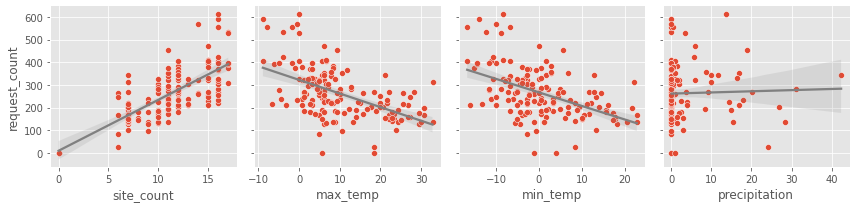

In [26]:
def multi_scatter(plotting_set, feature_names, y_var, order=1):
    g = sns.FacetGrid(
        pd.DataFrame(feature_names), 
        col=0, col_wrap=4, sharex=False
    )
    for ax, x_var in zip(g.axes, feature_names):
        kwargs = {
            "data": plotting_set, 
            "x": x_var,
            "y": y_var, 
            "ax": ax,
        }
        sns.scatterplot(**kwargs)
        sns.regplot(**kwargs, scatter=False, color="grey", order=order)
    g.tight_layout()
    plt.show()
    

multi_scatter(met, ["site_count", "max_temp", "min_temp", "precipitation"], y_var="request_count")

### Dealing with categorical variables  
#### One-Hot-Encoding
In most of the machine learning algorithms barring a a few (ex. Decision Tree) we need numerical values for the input features. In this data `events` is a categorical variable which should be one-hot-encoded, meaning that every unique value of an encoded column is represented in a new column, and binary values in those columns tell whether or not the original categorical variable has that value in a given sample.
![](https://i.imgur.com/mtimFxh.png)

The numerical values of `day` and `events` do not signify anything in a linear sense, so they need to be one-hot-encoded to be used as a feature input vector.

In [27]:
# Extract the weekday for each date
X.loc[:, 'day'] = X['date'].dt.day_name()
dummy_cols = ["events", "day"]
X = pd.get_dummies(X, columns=dummy_cols, prefix=dummy_cols)

# Drop redundant columns, now that we have dummy variables instead
X = X.drop("date", axis=1)
X.head()

,calendar_code,site_count,max_temp,min_temp,precipitation,events_Fog,events_Fog-Rain,events_Fog-Rain-Snow,events_Fog-Snow,events_None,...,events_Rain-Snow,events_Rain-Thunderstorm,events_Snow,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,0.0,6,30.6,22.8,0.0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1.0,7,32.8,22.8,15.5,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,1.0,7,29.4,18.3,0.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,1.0,7,29.4,17.2,0.0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,1.0,7,30.6,21.7,0.0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


We use a correlation matrix for dependence on the categorical variables 

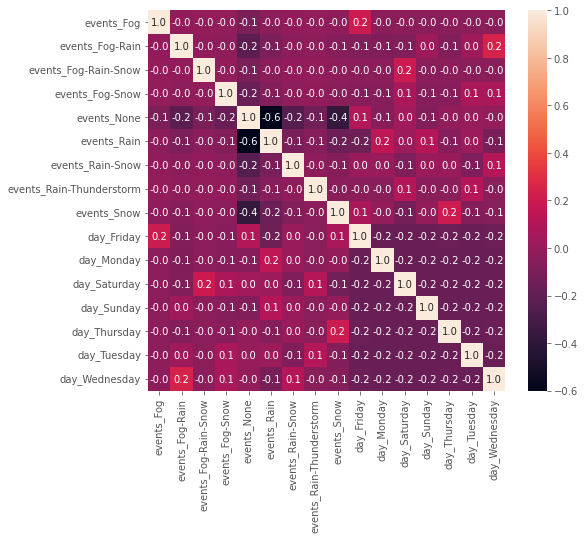

In [28]:
plt.figure(figsize=(8, 7))
sns.heatmap(X.iloc[:, 5:].corr(), annot=True, fmt=".1f");

One of the conditions of OLS (From the Gauss-Markov theorem) states that the independent variables $\mathbf{X}$ must be independent. Most of the columns in our data set are not dependent though, which is good. Curiously, we see a correlation of -0.6 between `events_None` and `events_Rain`, which is strange since they should be mutually exclusive as a result of one-hot-encoding `events`. We have a very small data set size, though, which might explain that.  
There are ways to deal with collinearity of variables, such as with *instrumental variables*, as we will detail later in the course, but for now we leave the correlated variables in and note to ourselves that statistical rigor does not guarantee that the normal equation yields an optimal solution. In practice, however, it often produces more than good enough solutions.  

# Task 1: Feature Engineering
It appears that the number of requests has some kind of a quadratic dependence on the mean temperature so in addition to max and min temperature we should construct a new feature, e.g. $((min\_temp+max\_temp)/2)^{2}$. Feature engineering is one way of bringing in domain knowledge or experience into the analysis. Add one or more features to X.  

### Be creative  
Try to create features that result in a high performing model. Use your data visualization skills and intuition to do this. How can features be processed or combined so that the overall prediction ability of the model is increased?

In [161]:
# TODO: Add one or more features to X
# Code below is copied from other cells to make rerunning easier
##########
met = pd.read_csv("met.csv", index_col=0)
met = met.dropna()
met.date = pd.to_datetime(met.date, format="%Y-%m-%d")
met.head()

X = met.loc[:, met.columns != "request_count"]
y = met["request_count"]

# Extract the weekday for each date
X.loc[:, 'day'] = X['date'].dt.day_name()
dummy_cols = ["events", "day"]
X = pd.get_dummies(X, columns=dummy_cols, prefix=dummy_cols)

# Drop redundant columns, now that we have dummy variables instead
X = X.drop("date", axis=1)
##########

X = np.column_stack((X, 0.5*(X['min_temp'] + X['max_temp'])**2))#, np.exp(X['events_Rain'])))
X = sm.add_constant(X)

#X = (X - X.mean()) / X.std()

## Task 2: Conduct a MLR on the dataset and evaluate performance both on the training and the test data  
### Splitting the data into training and test set
We can always tune the hyperparameters so much that the model performs well on the training data, but it fails to generalize on the unseen data. To negate this we split the available data into training and test sets. We want somewhat similar performance on both sets.  

In [168]:
#Split the data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

# Train a regression model using statsmodels and the training data
model = sm.OLS(y_train, X_train).fit()
#print(model.summary2())

# Perform prediction
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Report MSE of both sets
mse_train = np.mean((y_pred_train - y_train)**2, axis=0)
mse_test = np.mean((y_pred_test - y_test)**2, axis=0)
print(f"MSE for the training set: {mse_train}")
print(f"MSE for the test set: {mse_test}")

# Report R^2 of both sets
from sklearn.metrics import r2_score
rsq_train = r2_score(y_train, y_pred_train)
rsq_test = r2_score(y_test, y_pred_test)
print(f"Rsq for the training set: {rsq_train}")
print(f"Rsq for the test set: {rsq_test}")

MSE for the training set: 1835.8619396288973
MSE for the test set: 5361.312899715177
Rsq for the training set: 0.7399425927232035
Rsq for the test set: 0.6619149328643309


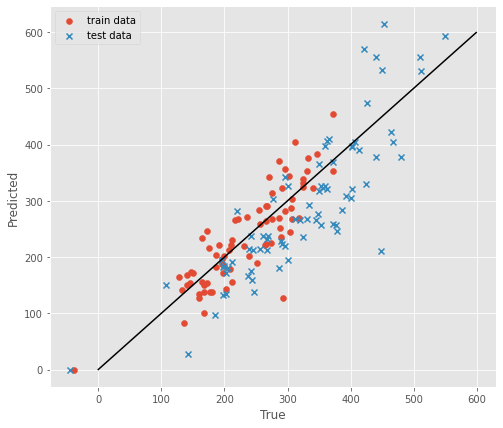

In [169]:
# Plotting predicted vs true values
x = range(600)
plt.figure(figsize=(8, 7))
plt.scatter(y_pred_train, y_train, label="train data")
plt.scatter(y_pred_test, y_test, label="test data", marker="x")
plt.plot(x, x, "k")
plt.legend()
plt.xlabel("True")
plt.ylabel("Predicted");

## Task 3: Fitting a LASSO-regularized model  
In this exercise, we want you to find the optimal regularization parameter $\lambda$ ($\alpha$ in `statsmodels`) by evaluating different parameter choices on a validation set. Optimally, we want our models to be as parsimonious as possible (Occam's razor), while being as predictive as possible. What we often find is that models include weights of features that do not add to the models predictive performance. Such weights we want to remove. One way of doing that is by doing feature selection using LASSO-regression.  

### Split the test set into equal parts test and validate

In [170]:
X_test_new, X_validate, y_test_new, y_validate = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)

### Make a regularization parameter selection scheme  
Use the skills you have learned in the lectures to find the $\alpha$ that you think generalizes the best to the test set. *Hint: train and evaluate many models with different $\alpha$-values and plot train and validation set performance of the model for each of them, with $\alpha$ on the x-axis.*

In [183]:
from sklearn.linear_model import Lasso

alphas = np.linspace(0, 1, 10000)

mse_best = np.Inf
alpha_best = -np.Inf

for alpha in alphas:
    model = Lasso(alpha)
    model.fit(X_train, y_train)
    y_pred_validate = model.predict(X_validate)
    mse_valid = np.mean((y_validate - y_pred_validate)**2)
    
    if mse_valid < mse_best:
        alpha_best = alpha
        mse_best = mse_valid
        
        #print("Coefficients that are zero: {}".format(np.where(model.coef_ == 0)))
        
print(f"alpha that yields the lowest mse for the validation set: {alpha_best}")

alpha that yields the lowest mse for the validation set: 0.3791379137913792


### Evaluate the regularized model's performance on the test set (which you should only expose the model to once)  
Calculate the train and test set MSE and R^2, like you did in task 2.  
Comment on how the new performance values differ from the values you got in task 2.

In [184]:
# Train a regression model using statsmodels and the training data
model = Lasso(alpha_best)
model.fit(X_test, y_test)

print(np.where(model.coef_ == 0))

# Perform prediction
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test_new)

# Report MSE of both sets
mse_train = np.mean((y_pred_train - y_train)**2, axis=0)
mse_test = np.mean((y_pred_test - y_test_new)**2, axis=0)
print(f"MSE for the training set: {mse_train}")
print(f"MSE for the new test set: {mse_test}")

# Report R^2 of both sets
from sklearn.metrics import r2_score
rsq_train = r2_score(y_train, y_pred_train)
rsq_test = r2_score(y_test_new, y_pred_test)
print(f"Rsq for the training set: {rsq_train}")
print(f"Rsq for the new test set: {rsq_test}")

(array([ 0,  6,  7, 12, 13, 21]),)
MSE for the training set: 5104.602238345576
MSE for the new test set: 1481.840163860477
Rsq for the training set: 0.2769120625966992
Rsq for the new test set: 0.7295810956221789


## Comments

Since LASSO yields a model where some of the coefficients are zero, then I would expect the performance of the projection onto the original training set to be worse than in task 2, since setting some coefficients to be zero is equivalent to not using the information along these dimensions when predicting. This is indeed the case, as can be seen by the MSE and Rsq values above.

However, I did not expect the performance for the test set to be as good as it is here. What appears to have happened is that selecting an alpha that minimizes MSE on the validation set is equivalent to the model order selection schemes that have been presented previously. In that case we avoid over/underfitting to the training set, and thus yielding a model that performs reasonably well on new data